# Using xCEBRA: Time-series attribution maps with regularized contrastive learning

**AISTATS 2025**

- **ABSTRACT**: Gradient-based attribution methods aim to explain decisions of deep learning models but so far lack identifiability guarantees. Here, we propose a method to generate attribution maps with identifiability guarantees by developing a regularized contrastive learning algorithm trained on time-series data plus a new attribution method called Inverted Neuron Gradient (collectively named xCEBRA). We show theoretically that xCEBRA has favorable properties for identifying the Jacobian matrix of the data generating process. Empirically, we demonstrate robust approximation of zero vs. non-zero entries in the ground-truth attribution map on synthetic datasets, and significant improvements across previous attribution methods based on feature ablation, Shapley values, and other gradient-based methods. Our work constitutes a first example of identifiable inference of time-series attribution maps and opens avenues to a better understanding of time-series data, such as for neural dynamics and decision-processes within neural networks.
  
- If you find this helpful, please cite: Schneider, Steffen, et al. *Time-Series Attribution Maps with Regularized Contrastive Learning*. The 28th International Conference on Artificial Intelligence and Statistics, 2025. [https://openreview.net/forum?id=aGrCXoTB4P](https://openreview.net/forum?id=aGrCXoTB4P).

In [1]:
import pickle
import torch
import numpy as np

import matplotlib.pyplot as plt
from cebra.data import DatasetxCEBRA, ContrastiveMultiObjectiveLoader
import cebra
from cebra.data import TensorDataset

from cebra.solver import MultiObjectiveConfig
from cebra.solver.schedulers import LinearRampUp
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit


## Load the data & create dataset

In [2]:
# download the data from: https://zenodo.org/record/15267195/
import requests

url = "https://zenodo.org/records/15267195/files/cynthi_neurons90_gridbase0.5_gridmodules3_grid_head_direction_place_speed_duration2000_noise0.25_bs100_seed231209234.p?download=1"
response = requests.get(url)

with open("cynthi_neurons90.p", "wb") as f:
    f.write(response.content)

In [3]:
file = "cynthi_neurons90.p"
with open(file, 'rb') as f:
    dataset = pickle.load(f)
print(dataset.keys())

dict_keys(['position', 'x', 'y', 'firing_rates', 'spikes', 'time', 'grid_scales', 'environment', 'agent', 'cells', 'speed', 'velocity_x', 'velocity_y', 'heading', 'heading_sincos', 'circ_coords_pi', 'circ_coords_cart_0.2_0.1', 'circ_coords_toro_0.2_0.1', 'circ_coords_cart_0.5_0.1', 'circ_coords_toro_0.5_0.1', 'circ_coords_cart_0.5_0.2', 'circ_coords_toro_0.5_0.2', 'circ_coords_cart_1_0.1', 'circ_coords_toro_1_0.1', 'circ_coords_cart_1_0.2', 'circ_coords_toro_1_0.2', 'circ_coords_cart_1_0.5', 'circ_coords_toro_1_0.5', 'circ_coords_cart_2_0.1', 'circ_coords_toro_2_0.1', 'circ_coords_cart_2_0.2', 'circ_coords_toro_2_0.2', 'circ_coords_cart_2_0.5', 'circ_coords_toro_2_0.5', 'circ_coords_cart_2_1', 'circ_coords_toro_2_1', 'rms', 'tc_hd', 'tc_speed', 'speed_score', 'hd_score', 'grid_score', 'spatial_info_score', 'spatial_stability', 'hd_stability', 'speed_stability'])


In [4]:
neural = torch.FloatTensor(dataset['spikes']).float()
position = torch.FloatTensor(dataset['position']).float()

# create dataset
data = DatasetxCEBRA(
    neural, 
    position=position
)

## Visualize neural data and position

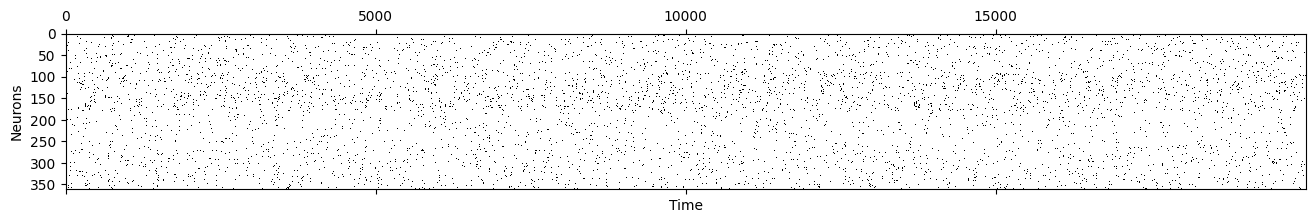

In [5]:
plt.matshow(neural.T, aspect="auto", cmap="Greys")
plt.ylabel("Neurons")
plt.xlabel("Time")
plt.show()

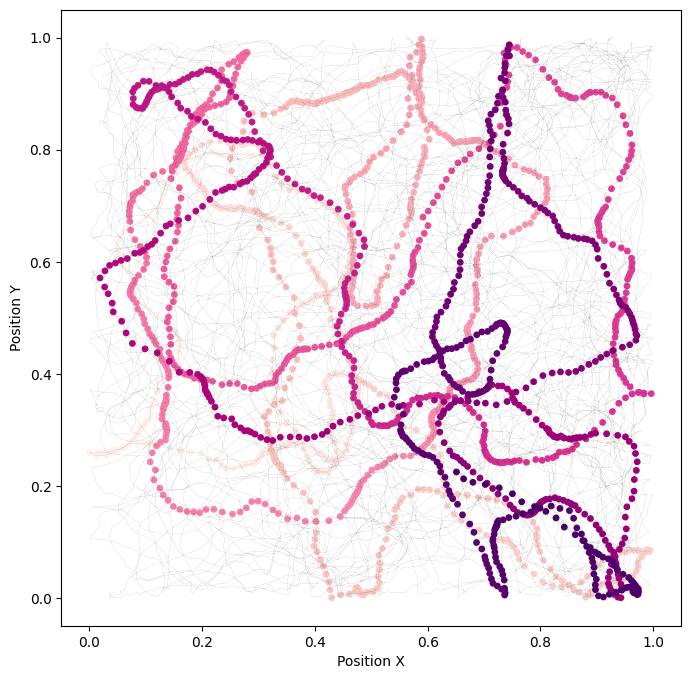

In [6]:
plt.figure(figsize=(8, 8))  # Set a larger figure size
traj_to = 2000
highlight_range = slice(250, 260)
plt.plot(position[0::,0], position[0::,1], 'k', linewidth=0.1, alpha=0.45)
cl = plt.scatter(position[0:traj_to,0], position[0:traj_to,1], c=np.arange(0, traj_to), cmap='RdPu', s=15)
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.show()

In [7]:
# To do: set target attribution
#ground_truth_attribution = dataset['ground_truth_attribution']
#plt.matshow(dataset['ground_truth_attribution'], aspect="auto")
#plt.title("Ground truth attribution map")
#plt.xlabel("Neurons")
#plt.ylabel("Latents")
#plt.colorbar()
#plt.show()

## Train a model

### 1. Define parameters

In [8]:
behavior_indices = (0, 4)
time_indices = (0, 14)

num_steps = 1000 
device = "cpu" #"cuda_if_available"
n_latents = 14

### 2. Define loader, model and solver

- this is the pytorch API for CEBRA: https://cebra.ai/docs/api.html

In [9]:
loader = ContrastiveMultiObjectiveLoader(dataset=data,
                                         num_steps=num_steps,
                                         batch_size=2_500).to(device)
config = MultiObjectiveConfig(loader)

config.set_slice(*behavior_indices)
config.set_loss("FixedCosineInfoNCE", temperature=1.)
config.set_distribution("time_delta", time_delta=1, label_name="position")
config.push()

config.set_slice(*time_indices)
config.set_loss("FixedCosineInfoNCE", temperature=1.)
config.set_distribution("time", time_offset=10)
config.push()

config.finalize()

criterion = config.criterion
feature_ranges = config.feature_ranges


neural_model = cebra.models.init(
    name="offset10-model",
    num_neurons=data.neural.shape[1],
    num_units=256,
    num_output=n_latents,
).to(device)

data.configure_for(neural_model)

opt = torch.optim.Adam(
    list(neural_model.parameters()) + list(criterion.parameters()),
    lr=3e-4,
    weight_decay=0,
) 

regularizer = cebra.models.jacobian_regularizer.JacobianReg()

solver = cebra.solver.init(
    name="multiobjective-solver",
    model=neural_model,
    feature_ranges=feature_ranges,
    regularizer = regularizer,
    renormalize=True,
    use_sam=False,
    criterion=criterion,
    optimizer=opt,
    tqdm_on=True,
).to(device)

Adding configuration for slice: (0, 4)
Adding configuration for slice: (0, 14)
Adding distribution of slice: (0, 4)
Adding distribution of slice: (0, 14)
Creating MultiCriterion
Computing renormalized ranges...
New ranges: [slice(0, 4, None), slice(4, 14, None)]


### 3. Define weight scheduler for regularizer and train model

In [10]:
weight_scheduler = LinearRampUp(
    n_splits=2,
    step_to_switch_on_reg= num_steps // 4,
    step_to_switch_off_reg= num_steps // 2,
    start_weight=0.,
    end_weight=0.1, 
)

solver.fit(loader=loader,
           valid_loader=None,
           log_frequency=None,
           scheduler_regularizer = weight_scheduler,
           scheduler_loss = None,
)

sum_loss_train:  13.5731:  25%|██████▌                   | 250/1000 [37:42<1:44:46,  8.38s/it]/Users/mwmathis/miniconda/envs/DEEPLABCUT/lib/python3.13/site-packages/cebra/models/jacobian_regularizer.py:118: UserWarning: This overload of addcdiv is deprecated:
	addcdiv(Tensor input, Number value, Tensor tensor1, Tensor tensor2, *, Tensor out = None)
Consider using one of the following signatures instead:
	addcdiv(Tensor input, Tensor tensor1, Tensor tensor2, *, Number value = 1, Tensor out = None) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  v = torch.addcdiv(arxilirary_zero, 1.0, v, vnorm)
sum_loss_train:  13.5001: 100%|█████████████████████████| 1000/1000 [4:09:27<00:00, 14.97s/it]


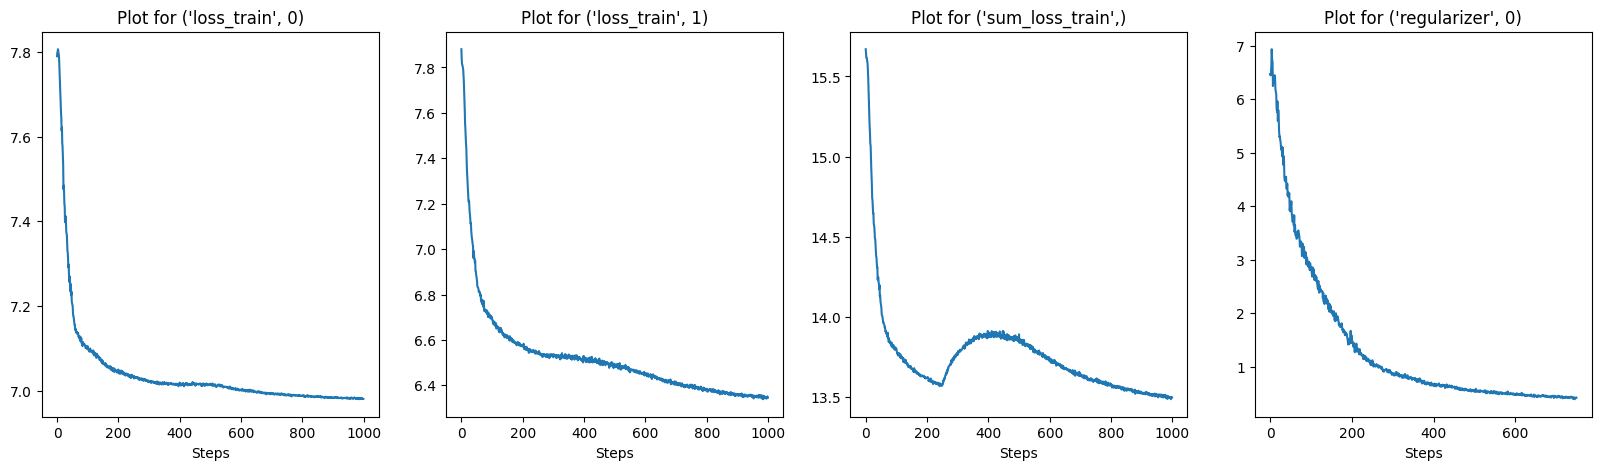

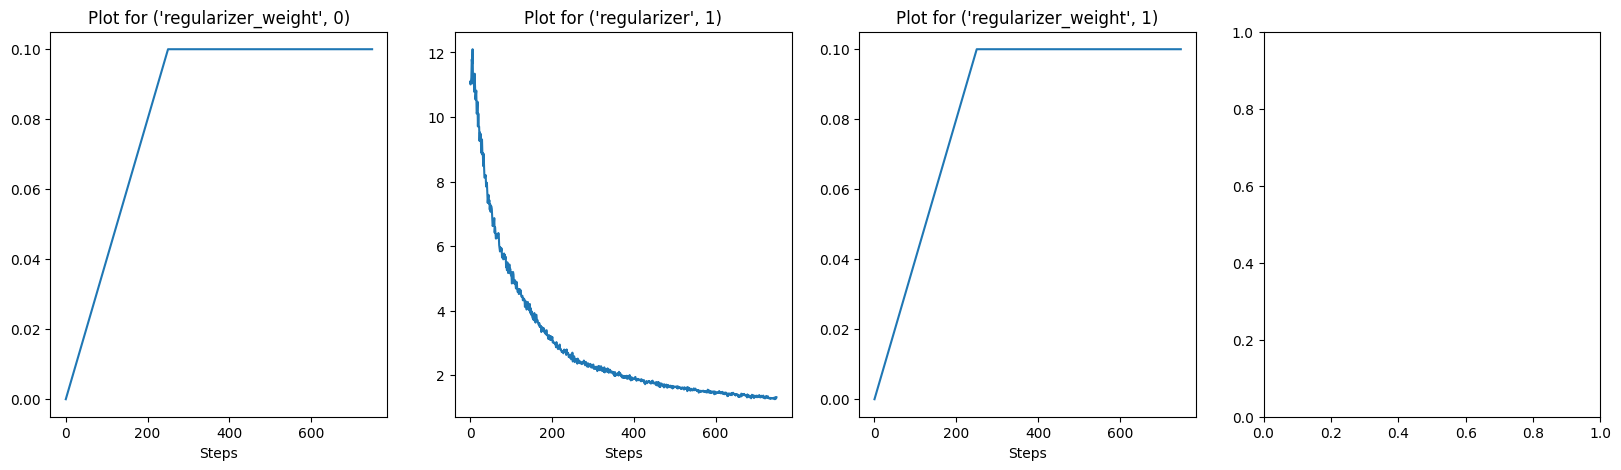

In [11]:
# Plot every key in solver.log
keys = list(solver.log.keys())
for i in range(0, len(keys), 4):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for j, key in enumerate(keys[i:i+4]):
        axs[j].plot(solver.log[key])
        axs[j].set_title(f"Plot for {key}")
        axs[j].set_xlabel("Steps")
        axs[j].set_ylabel("Value")
    plt.show()

## Compute embedding

In [12]:
data_emb = TensorDataset(neural, continuous=torch.zeros(len(data.neural)))
data_emb.configure_for(solver.model)
data_emb = data_emb[torch.arange(len(data_emb))]

solver.model.split_outputs = False
embedding = solver.model(data_emb.to(device)).detach().cpu()

## Compute R2 / KNN score 

In [13]:
time_indices_for_score = slice(4, 14)

In [14]:
X_behavior = embedding[:, slice(*behavior_indices)]
X_time = embedding[:, time_indices_for_score]
y = position

# Linear regression
linear_model_time = LinearRegression()
R2_time = linear_model_time.fit(X_time, y).score(X_time, y)

linear_model_behavior = LinearRegression()
R2_behavior = linear_model_behavior.fit(X_behavior, y).score(X_behavior, y)

print(f"R2 time: {R2_time: .2f}")
print(f"R2 behavior: {R2_behavior: .2f}")

R2 time:  0.67
R2 behavior:  0.87


In [15]:
tscv = TimeSeriesSplit(n_splits=5)
knn_model_time = KNeighborsRegressor()
knn_model_behavior = KNeighborsRegressor()

average_KNN_time = []
average_KNN_behavior = []

# Time series cross-validation for time features
for train_index, val_index in tscv.split(X_time):
    X_time_train, X_time_val = X_time[train_index], X_time[val_index]
    y_time_train, y_time_val = y[train_index], y[val_index]
    knn_model_time.fit(X_time_train, y_time_train)
    average_KNN_time.append(knn_model_time.score(X_time_val, y_time_val))

# Time series cross-validation for behavior features
for train_index, val_index in tscv.split(X_behavior):
    X_behavior_train, X_behavior_val = X_behavior[train_index], X_behavior[val_index]
    y_behavior_train, y_behavior_val = y[train_index], y[val_index]
    knn_model_behavior.fit(X_behavior_train, y_behavior_train)
    average_KNN_behavior.append(knn_model_behavior.score(X_behavior_val, y_behavior_val))

# Calculate the average R2 scores
average_KNN_time = sum(average_KNN_time) / tscv.n_splits
average_KNN_behavior = sum(average_KNN_behavior) / tscv.n_splits

print(f"KNN score time: {average_KNN_time: .2f}")
print(f"KNN score behavior: {average_KNN_behavior: .2f}")

KNN score time:  0.59
KNN score behavior:  0.94


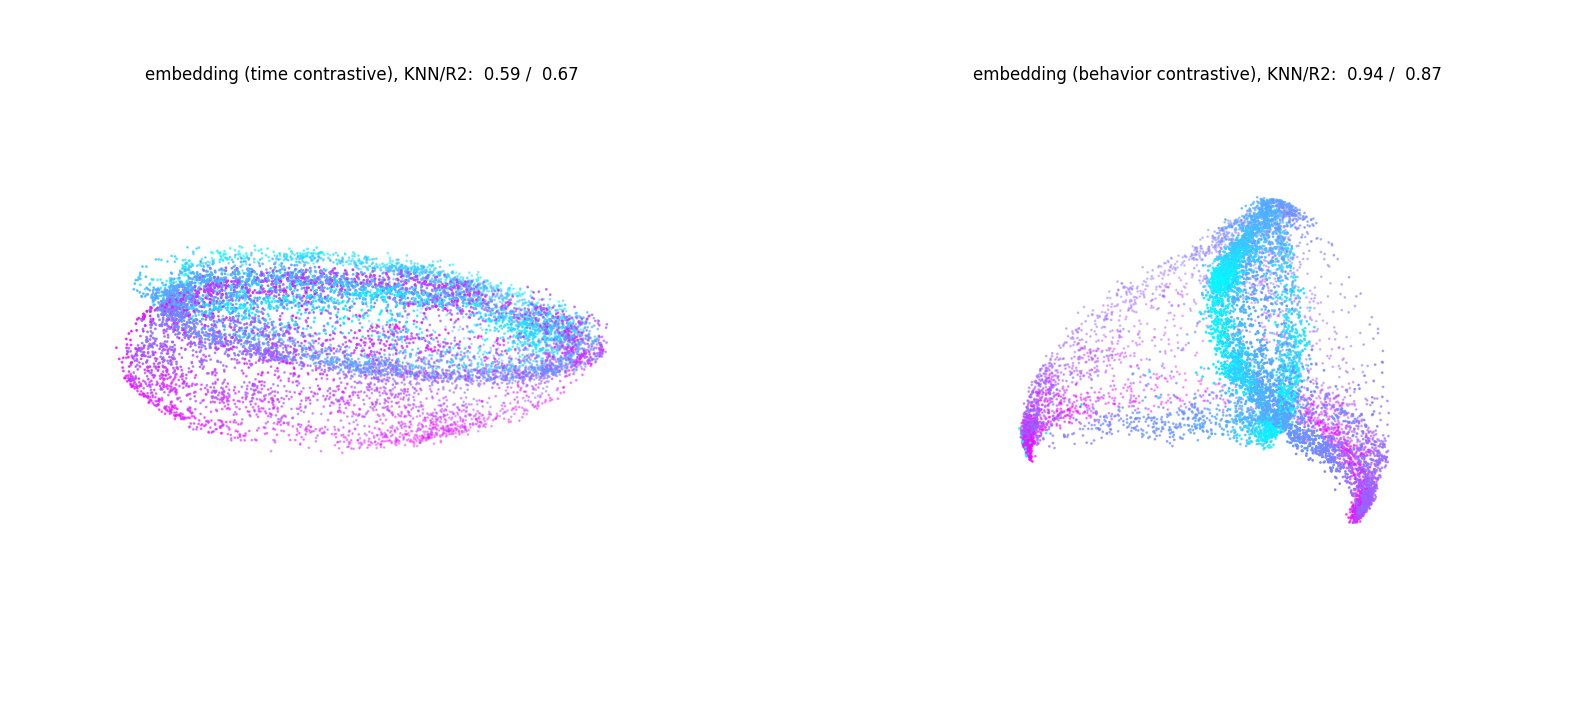

In [16]:
fig = plt.figure(figsize=(20, 15))

idx0_behavior, idx1_behavior, idx2_behavior = 0,1,2
idx0_time, idx1_time, idx2_time = 4,5,6
min_, max_ = 0, 10_000

ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(embedding[:, idx0_time][min_:max_],
                       embedding[:, idx1_time][min_:max_],
                       embedding[:, idx2_time][min_:max_],
                       c=position[:, 0][min_:max_], s=1, cmap="cool")
ax1.set_title(f'embedding (time contrastive), KNN/R2: {average_KNN_time: .2f} / {R2_time: .2f}', y=1.0, pad=-10)
ax1.set_axis_off()

ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(embedding[:, idx0_behavior][min_:max_],
                       embedding[:, idx1_behavior][min_:max_],
                       embedding[:, idx2_behavior][min_:max_],
                       c=position[:, 1][min_:max_], s=1, cmap="cool")
ax2.set_title(f'embedding (behavior contrastive), KNN/R2: {average_KNN_behavior: .2f} / {R2_behavior: .2f}', y=1.0, pad=-10)
ax2.set_axis_off()

plt.show()


## Compute attribution map, AUC and visualize it

In [17]:
attribution_split = 'train'
model = solver.model.to(device)
model.split_outputs = False
neural.requires_grad_(True)

method = cebra.attribution.init(
    name="jacobian-based",
    model=model,
    input_data=neural,
    output_dimension=model.num_output
    )

result = method.compute_attribution_map()

/Users/mwmathis/miniconda/envs/DEEPLABCUT/lib/python3.13/site-packages/cebra/__init__.py:118: UserWarning: Your code triggered a lazy import of cebra.attribution. While this will (likely) work, it is recommended to add an explicit import statement to you code instead. To disable this warning, you can run ``cebra.allow_lazy_imports()``.
  warnings.warn(


Computing inverse for jf with method lsq
Computing inverse for jf with method svd
Computing inverse for jf-convabs with method lsq
Computing inverse for jf-convabs with method svd


In [18]:
jf = abs(result['jf']).mean(0)
jfinv = abs(result['jf-inv-svd']).mean(0)
jfconvabsinv = abs(result['jf-convabs-inv-svd']).mean(0)

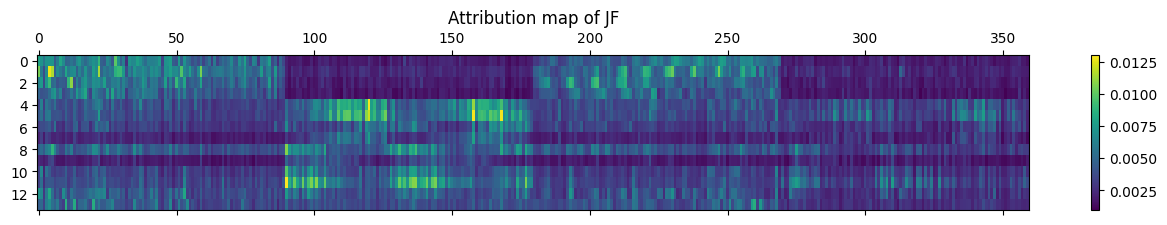

In [19]:
plt.matshow(jf, aspect="auto")
plt.colorbar()
plt.title("Attribution map of JF")
plt.show()

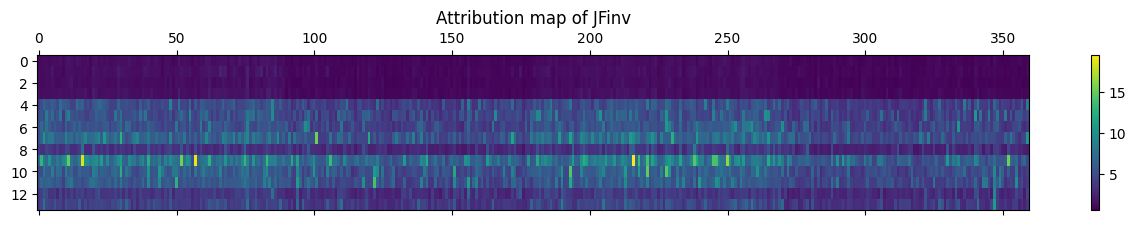

In [20]:
plt.matshow(jfinv, aspect="auto")
plt.colorbar()
plt.title("Attribution map of JFinv")
plt.show()

## Hypothesis-guided attribution
- Next, we can develop a hypothesized latent graph that gives rise to the functional cell types (speed, grid, place, etc).
- This allows us to compute the real vs. this hypothesized "ground_truth" (or on synthetics data, you have real GT).

[['position', 'grid'], ['position', 'grid'], ['position', 'grid'], ['speed'], ['speed'], ['speed'], ['speed'], ['speed'], ['speed'], ['speed'], ['speed'], ['speed'], ['speed'], ['speed']]


<Figure size 800x600 with 0 Axes>

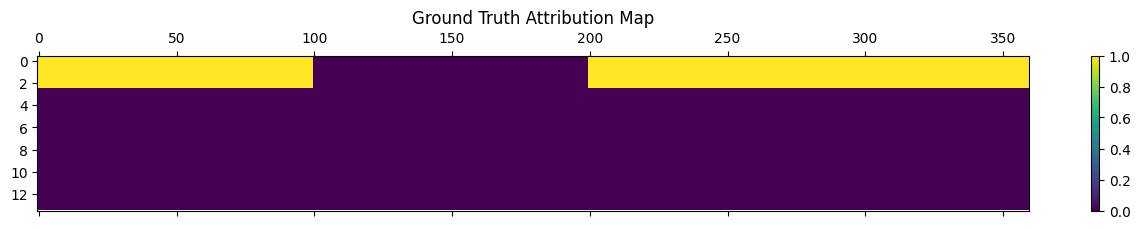

In [39]:
## Define your cell types
import itertools
cells = [
    ["position"] * 100,
    ["hd"] * 100,
    ["position"] * 100,
    ["grid"] * 60,
]
cells = np.array(list(itertools.chain.from_iterable(cells)))

## Mappings from cell types to hypotheses
## each latent group should be trained with
# auxiliary variables related to the specified cell types 
latents = [
    (["position", "grid"], 3),  # Repeat position+grid group 3 times
    (["speed"], 11),  # Repeat speed group 11 times
]
latents = [group for group, repeats in latents for _ in range(repeats)]
print(latents)

ground_truth_attribution = np.zeros((len(latents), len(cells)), dtype=bool)

for i, latent in enumerate(latents):
    for j, cell_type in enumerate(cells):
        ground_truth_attribution[i, j] = cell_type in latent

plt.figure(figsize=(8, 6))
plt.matshow(ground_truth_attribution, aspect ='auto')
plt.colorbar()
plt.title('Ground Truth Attribution Map')
plt.show()

In [40]:
auc_jf = method.compute_attribution_score(jf, ground_truth_attribution)
auc_jfinv = method.compute_attribution_score(jfinv,  ground_truth_attribution)
auc_jfconvabsinv = method.compute_attribution_score(jfconvabsinv,  ground_truth_attribution)
print(f"auc_jf, {auc_jf: .2f}")
print(f"auc_jfinv, {auc_jfinv: .2f}")
print(f"auc_jfconvabsinv, {auc_jfconvabsinv: .2f}")

auc_jf,  0.58
auc_jfinv,  0.09
auc_jfconvabsinv,  0.24
